<a href="https://colab.research.google.com/github/Moukthika1253/NaiveBayesClassifier-Rotten-Tomato-reviews/blob/main/NBC_Rotten_tomato_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string,re
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.stem import PorterStemmer
import math

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
rt_df=pd.read_csv('/content/rt_reviews.csv',encoding='latin-1')

# Splitting data into Train-50%, Dev-20%, Test-30%

In [14]:
X_train,X_remaining, y_train, y_remaining= train_test_split(rt_df['Review'],rt_df['Freshness'],train_size=0.5)
X_test, X_dev, y_test, y_dev = train_test_split(X_remaining,y_remaining,test_size=0.3)
train_set=pd.concat([X_train,y_train],axis=1).reset_index(drop=True)
dev_set=pd.concat([X_dev,y_dev],axis=1).reset_index(drop=True)
test_set=pd.concat([X_test,y_test],axis=1).reset_index(drop=True)
print(f"Train set size:  ",train_set.size)
print(f"Dev set size:  ",dev_set.size)
print(f"Test set size:  ",test_set.size)

Train set size:   480000
Dev set size:   144000
Test set size:   336000


In [15]:
train_set.head()

,Review,Freshness
0,These two vets of showbiz wars smartly play o...,fresh
1,A cursory affair that skimps on depth in favo...,rotten
2,"This talky, heavy melodrama is pretty to look...",rotten
3,Once the chaotic adult-fairy-tale elements ov...,rotten
4,"The film's stunt is to unveil a simple truth,...",fresh


# Pre-processing

In [16]:
def preprocessing(review):
  stop_words=stopwords.words('english')
  word_lemmatizer=WordNetLemmatizer()
  tokenized_words=[(word) for word in word_tokenize(review)]
  words=[word.lower() for word in tokenized_words if word.lower() not in stop_words]
  for i in range(len(words)):
   words[i]=''.join([word for word in words[i] if word not in (string.punctuation)])
  no_emptywords=[word for word in words if word]
  no_extraspace=[re.sub(r'\s\s+', '',word) for word in no_emptywords]
  lemmatized_words=[word_lemmatizer.lemmatize(word) for word in no_extraspace]
  return lemmatized_words 
  

In [17]:
train_set['Review']=train_set['Review'].apply(preprocessing)
train_set.head()

,Review,Freshness
0,"[two, vet, showbiz, war, smartly, play, iconic...",fresh
1,"[cursory, affair, skimps, depth, favor, uplift...",rotten
2,"[talky, heavy, melodrama, pretty, look, behind...",rotten
3,"[chaotic, adultfairytale, element, override, f...",rotten
4,"[film, s, stunt, unveil, simple, truth, reputa...",fresh


In [18]:
preprocessing("Story inspired by historical events that illustrates the process whereby enemies can become friends.")

['story',
 'inspired',
 'historical',
 'event',
 'illustrates',
 'process',
 'whereby',
 'enemy',
 'become',
 'friend']

**Calculating Total number of words in Vocab**

In [99]:
review_list=[]
for i,review in train_set['Review'].items():
  for word in review:
    review_list.append(word)
review_list=list(set(review_list))
tot_words=len(review_list)
print(f"total number of words in the list: {tot_words}")

total number of words in the list: 86750


In [100]:
pos_reviews=0
neg_reviews=0
num_pos_words=0
num_neg_words=0
pos_words=[]
neg_words=[]
word_dict=defaultdict(lambda:[0,0])
freshness=list(train_set['Freshness'])

# Calculating word frequencies for each word in fresh and rotten review

In [88]:
for i, review in enumerate(list(train_set['Review'])):
  if  freshness[i] == 'fresh':
    pos_reviews=pos_reviews+1
  else:
    neg_reviews=neg_reviews+1
  for word in (review):
    if freshness[i] == 'fresh':
      word_dict[word][1]+=1
      num_pos_words+=1
      pos_words.append(word)
    else:
      word_dict[word][0]+=1
      num_neg_words+=1
      neg_words.append(word)

In [89]:
(word_dict)

defaultdict(<function __main__.<lambda>()>,
            {'two': [2607, 2290],
             'vet': [17, 17],
             'showbiz': [29, 45],
             'war': [985, 1522],
             'smartly': [14, 157],
             'play': [1835, 1537],
             'iconic': [72, 132],
             'past': [610, 765],
             'cursory': [39, 5],
             'affair': [419, 233],
             'skimps': [17, 8],
             'depth': [490, 482],
             'favor': [213, 95],
             'uplifting': [44, 209],
             'soundbites': [2, 3],
             'choppedup': [8, 0],
             'snippet': [19, 10],
             'performance': [2512, 5855],
             'footage': [216, 350],
             'talky': [97, 45],
             'heavy': [305, 238],
             'melodrama': [633, 483],
             'pretty': [1318, 979],
             'look': [2474, 2649],
             'behind': [569, 642],
             'nothing': [2689, 1064],
             'substance': [448, 195],
             'cha

# Probability calculation

**P(fresh) and P(rotten)**

In [23]:
prob_rotten=train_set['Freshness'].value_counts(normalize=True)['rotten']
prob_fresh=train_set['Freshness'].value_counts(normalize=True)['fresh']
print(f'P(fresh) = {prob_fresh} P(rotten) = {prob_rotten}')

P(fresh) = 0.4999625 P(rotten) = 0.5000375


**P(word)**

In [24]:
def word_alone_prob(word):
  return ((word_dict[word][1]/num_pos_words))+((word_dict[word][0]/num_neg_words))

In [90]:
word_alone_prob('adonis')

3.8509749705881785e-06

**P(word|fresh) and P(word|rotten)**

In [94]:
def word_prob(reviewType, word):
  if reviewType == 'fresh':
    return math.log(word_dict[word][1]/num_pos_words)
  else:
    return math.log(word_dict[word][0]/num_neg_words)

In [95]:
word_prob('rotten','adonis')

ValueError: ignored

In [96]:
def word_prob(reviewType, word):
  if reviewType == 'fresh':
    return (word_dict[word][1]/num_pos_words)
  else:
    return (word_dict[word][0]/num_neg_words)
  

In [92]:
word_prob('fresh','adonis')

3.8509749705881785e-06

In [97]:
word_prob('rotten','adonis')

0.0

**P(fresh|review) and P(rotten|review)**

In [31]:
def withoutSmoothing_probability(reviewType, review):
  if reviewType == 'fresh':
    prob=math.log(pos_reviews/len(rt_df))
  else:
    prob=math.log(neg_reviews/len(rt_df))
  preprocessed_reviews=[]
  preprocessed_reviews=preprocessing(review)
  for word in preprocessed_reviews:
     prob=prob+word_prob(reviewType,word)
  return prob
    

# Class Prediction

In [32]:
def predict_class_withoutSmoothing(sentence):
 if withoutSmoothing_probability('fresh',sentence)*prob_fresh > withoutSmoothing_probability('rotten',sentence)*prob_rotten:
   return "fresh"
 else:
    return "rotten"

# Dev and Test accuracy without Smoothing

In [33]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class_withoutSmoothing(word) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [34]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.6402638888888889


In [35]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class_withoutSmoothing(word) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [36]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.6420238095238096


# Experiments

# Applied Smoothing

**P(word)**

In [37]:
alpha=1
def word_only_prob(word,num_words):
  return (math.log((word_dict[word][1]+alpha)/(num_pos_words+num_words)))+(math.log((word_dict[word][0]+alpha)/(num_neg_words+num_words)))

In [101]:
word_only_prob('adonis',tot_words)

-22.741571395618212

**P(fresh|word) and P(rotten|word)**

In [39]:
def cond_prob(reviewType, word,num_words):
  if reviewType == 'fresh':
    return math.log((word_dict[word][1]+alpha)/(num_pos_words+(num_words)))
  else:
    return math.log((word_dict[word][0]+alpha)/(num_neg_words+(num_words)))

In [102]:
cond_prob('rotten','adonis',tot_words)

-11.370785697809106

**P(fresh|review) and P(rotten|review)**

In [41]:
def review_probability(reviewType, review,n):
  if reviewType == 'fresh':
    prob=math.log(pos_reviews/len(rt_df))
  else:
    prob=math.log(neg_reviews/len(rt_df))
  preprocessed_reviews=[]
  preprocessed_reviews=preprocessing(review)
  for word in preprocessed_reviews:
     prob=prob+cond_prob(reviewType,word,n)
  return prob
    

**Comparing probabilities of fresh and rotten class**

In [43]:
print(review_probability('fresh','Story inspired by historical events that illustrates the process whereby enemies can become friends.',tot_words))
print(review_probability('rotten','Story inspired by historical events that illustrates the process whereby enemies can become friends.',tot_words))

-89.63943568807176
-92.5862366173494


**Class prediction**

In [44]:
def predict_class(sentence,n):
 if review_probability('fresh',sentence,n)+prob_fresh > review_probability('rotten',sentence,n)+prob_rotten:
   return "fresh"
 else:
    return "rotten"

In [45]:
predict_class('Story inspired by historical events that illustrates the process whereby enemies can become friends.',tot_words)

'fresh'

# Deriving top 10 words that predict each class

In [46]:
def topmost_prob(pos_word):
  p={}
  for i in range(len(pos_word)):
   num=(cond_prob('fresh',pos_word[i],tot_words)*prob_fresh)/word_only_prob(pos_word[i],tot_words)
   p[pos_word[i]]=num
  return p

In [47]:
def topmost_negprob(neg_word):
  p={}
  for i in range(len(neg_word)):
   num=(cond_prob('rotten',neg_word[i],tot_words)*prob_rotten)/word_only_prob(neg_word[i],tot_words)
   p[neg_word[i]]=num
  return p

**Top 10 words that predict P(class=fresh|word)**

In [48]:
p=topmost_prob(pos_words)
top10_words=sorted(p.items(),key=lambda x:x[1],reverse=True)
print("Top 10 words         P[class='fresh'|word]")
for i, (k,v) in enumerate(top10_words[:10]):
 print(k,"                    ", v)


Top 10 words         P[class='fresh'|word]
squanders                      0.2975141753283332
unfunny                      0.29629741974171003
listless                      0.2888362185776123
lifeless                      0.28856959276265
tedious                      0.28789892810905726
halfhearted                      0.2877956368797236
bland                      0.2876346392275121
poorly                      0.2863784102066019
subpar                      0.28624381767500867
uninspired                      0.28624152829706606


**Top 10 words that predict P(class=rotten|word)**

In [49]:
p=topmost_negprob(neg_words)
top10_words=sorted(p.items(),key=lambda x:x[1],reverse=True)
print("Top 10 words         P[class='rotten'|word]")
for i, (k,v) in enumerate(top10_words[:10]):
 print(k,"                    ", v)

Top 10 words         P[class='rotten'|word]
masterfully                      0.2834180899913894
skilfully                      0.280659689429058
heartbreakingly                      0.2803665702400752
razorsharp                      0.2803665702400752
koreeda                      0.28021733843813434
deftly                      0.2801657605032665
dory                      0.2800664723664708
holofcener                      0.279120588253796
acutely                      0.27906078603659323
gem                      0.2790389506383279


 **Accuracy on dev dataset**

In [50]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,tot_words) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [51]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.7985277777777777


**Testing on Test dataset**

In [52]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,tot_words) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [53]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.7978988095238095


# After removing rare words (occurence<5)

In [64]:
word_dict_copy=word_dict.copy()
count=0
for i, (k,v) in enumerate(word_dict_copy.items()):
  if (v[0]<5 and v[1]<5):
    del(k)
    count+=1

In [65]:
print(f"Total number of rare words: {count}")
no_rarewords=tot_words-count

Total number of rare words: 61475


In [66]:
print(f'Total number of words after removing rarewords: {no_rarewords}')

Total number of words after removing rarewords: 25275


**Accuracy on dev dataset**

In [67]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,no_rarewords) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [68]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.7985833333333333


**Accuracy on Test dataset**

In [69]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,no_rarewords) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [70]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.7979880952380952


# Considering small dataset where total number of words=7000

**Selecting first 7000 most frequent occuring words from vocabulary**

In [71]:
word_dict = sorted(word_dict.items(),  key=lambda x : x[1][0] + x[1][1], reverse=True)[:7000]

In [72]:
word_dict = defaultdict(lambda: [0, 0], word_dict)

**Dev Accuracy**

In [73]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,15000) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [74]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.773125


**Test Accuracy**

In [75]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,15000) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [76]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.7742916666666667


# Comparing Dev and Test accuracies across different models

In [103]:
import pandas as pd
data={'Dev accuracy':[0.6402638888888889,0.7985277777777777,  0.7985833333333333, 0.773125],
      'Test accuracy':[0.6420238095238096,0.7978988095238095,  0.7979880952380952,0.7742916666666667]}
df=pd.DataFrame(data,index=['Before smoothing',"after smoothing","No rare words","total words=7000"])
print(df)

                  Dev accuracy  Test accuracy
Before smoothing      0.640264       0.642024
after smoothing       0.798528       0.797899
No rare words         0.798583       0.797988
total words=7000      0.773125       0.774292


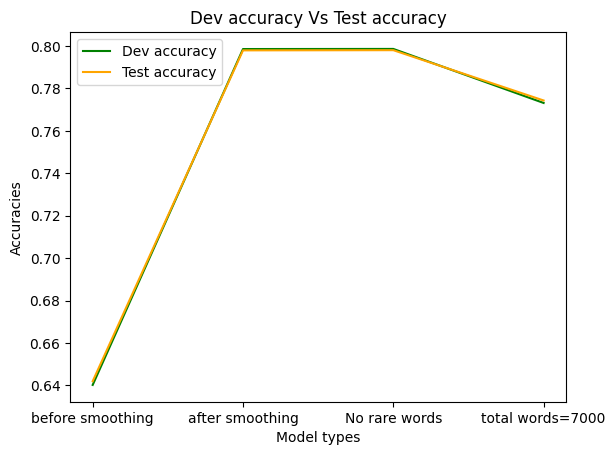

In [104]:
accuracies_dev=[0.6402638888888889,0.7985277777777777,  0.7985833333333333, 0.773125]
accuracies_test=[0.6420238095238096,0.7978988095238095,  0.7979880952380952,0.7742916666666667]
types=["before smoothing","after smoothing","No rare words","total words=7000"]
import matplotlib.pyplot as plt
plt.title("Dev accuracy Vs Test accuracy")
plt.plot(types,accuracies_dev,'g',label="Dev accuracy")
plt.plot(types,accuracies_test,'orange',label="Test accuracy")
plt.xlabel('Model types')
plt.ylabel('Accuracies')
plt.legend()
plt.show()